In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.0430 - acc: 0.1143
Epoch 00001: val_loss improved from inf to 3.00625, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_1_conv_checkpoint/001-3.0062.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 4.0429 - acc: 0.1143 - val_loss: 3.0062 - val_acc: 0.1148
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2237 - acc: 0.3670
Epoch 00002: val_loss did not improve from 3.00625
36805/36805 [==============================] - 42s 1ms/sample - loss: 2.2239 - acc: 0.3670 - val_loss: 3.6684 - val_acc: 0.1109
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7341 - acc: 0.4910
Epoch 00003: val_loss did not improve from 3.00625
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.7341 - acc: 0.4910 - val_loss: 4.0

36800/36805 [============================>.] - ETA: 0s - loss: 0.1262 - acc: 0.9648
Epoch 00029: val_loss did not improve from 3.00625
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1262 - acc: 0.9648 - val_loss: 10.4632 - val_acc: 0.1106
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1331 - acc: 0.9611
Epoch 00030: val_loss did not improve from 3.00625
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1331 - acc: 0.9611 - val_loss: 10.5193 - val_acc: 0.1153
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9642
Epoch 00031: val_loss did not improve from 3.00625
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1254 - acc: 0.9642 - val_loss: 10.9249 - val_acc: 0.0978
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1162 - acc: 0.9669
Epoch 00032: val_loss did not improve from 3.00625
36805/36805 [=====================

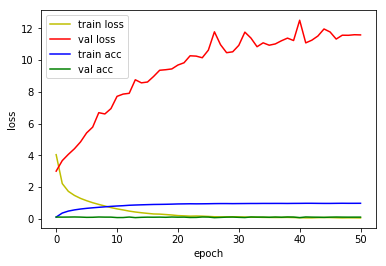

4815/4815 [==============================] - 2s 426us/sample - loss: 3.0644 - acc: 0.1020
Loss: 3.0644077859068464 Accuracy: 0.101973005

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0026 - acc: 0.2427
Epoch 00001: val_loss improved from inf to 3.17719, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_2_conv_checkpoint/001-3.1772.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 3.0026 - acc: 0.2427 - val_loss: 3.1772 - val_acc: 0.2348
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8908 - acc: 0.4863
Epoch 00002: val_loss improved from 3.17719 to 2.72158, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_2_conv_checkpoint/002-2.7216.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 1.8911 - acc: 0.4863 - val_loss: 2.7216 - val_acc: 0.3657
Epoch 3/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0919 - acc: 0.9785
Epoch 00029: val_loss did not improve from 2.72158
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0919 - acc: 0.9785 - val_loss: 6.2480 - val_acc: 0.3720
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9780
Epoch 00030: val_loss did not improve from 2.72158
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0925 - acc: 0.9780 - val_loss: 6.0199 - val_acc: 0.3757
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0701 - acc: 0.9820
Epoch 00031: val_loss did not improve from 2.72158
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0701 - acc: 0.9820 - val_loss: 6.1340 - val_acc: 0.3659
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0720 - acc: 0.9820
Epoch 00032: val_loss did not improve from 2.72158
36805/36805 [========================

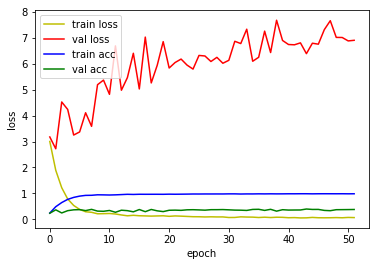

4815/4815 [==============================] - 4s 731us/sample - loss: 2.8316 - acc: 0.3246
Loss: 2.8315895648017477 Accuracy: 0.3246106

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1080 - acc: 0.3761
Epoch 00001: val_loss improved from inf to 1.79469, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_3_conv_checkpoint/001-1.7947.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.1081 - acc: 0.3761 - val_loss: 1.7947 - val_acc: 0.4477
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2548 - acc: 0.6199
Epoch 00002: val_loss did not improve from 1.79469
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.2549 - acc: 0.6199 - val_loss: 3.5024 - val_acc: 0.2863
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8874 - acc: 0.7292
Epoch 00003: val_loss did not improve from 1.79469
36805/36805 [=====

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9940
Epoch 00030: val_loss did not improve from 1.79469
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0309 - acc: 0.9940 - val_loss: 3.1503 - val_acc: 0.5073
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9942
Epoch 00031: val_loss did not improve from 1.79469
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0320 - acc: 0.9942 - val_loss: 2.9321 - val_acc: 0.5246
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9865
Epoch 00032: val_loss did not improve from 1.79469
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0573 - acc: 0.9865 - val_loss: 3.0355 - val_acc: 0.5348
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9916
Epoch 00033: val_loss did not improve from 1.79469
36805/36805 [===========

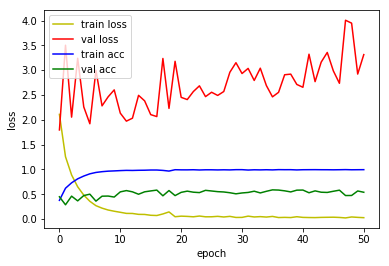

4815/4815 [==============================] - 4s 844us/sample - loss: 1.8795 - acc: 0.4295
Loss: 1.879499415222358 Accuracy: 0.42949116

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8377 - acc: 0.4319
Epoch 00001: val_loss improved from inf to 1.69651, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_4_conv_checkpoint/001-1.6965.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.8377 - acc: 0.4319 - val_loss: 1.6965 - val_acc: 0.4722
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2276 - acc: 0.6290
Epoch 00002: val_loss did not improve from 1.69651
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.2275 - acc: 0.6290 - val_loss: 2.3154 - val_acc: 0.4263
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9965 - acc: 0.6983
Epoch 00003: val_loss did not improve from 1.69651
36805/36805 [=====

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0762 - acc: 0.9854
Epoch 00029: val_loss did not improve from 1.32598
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0762 - acc: 0.9854 - val_loss: 2.3747 - val_acc: 0.5432
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0694 - acc: 0.9876
Epoch 00030: val_loss did not improve from 1.32598
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0694 - acc: 0.9876 - val_loss: 1.9970 - val_acc: 0.6014
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9871
Epoch 00031: val_loss did not improve from 1.32598
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0692 - acc: 0.9871 - val_loss: 2.0837 - val_acc: 0.5812
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9877
Epoch 00032: val_loss did not improve from 1.32598
36805/36805 [===========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0286 - acc: 0.9945
Epoch 00059: val_loss did not improve from 1.32598
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0286 - acc: 0.9945 - val_loss: 2.2440 - val_acc: 0.6061
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9939
Epoch 00060: val_loss did not improve from 1.32598
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0314 - acc: 0.9939 - val_loss: 1.6700 - val_acc: 0.6746

1D_CNN_custom_tanh_DO_025_DO_BN_4_conv Model


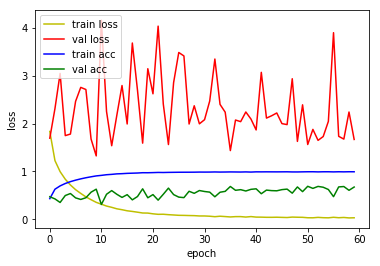

4815/4815 [==============================] - 4s 873us/sample - loss: 1.3915 - acc: 0.6079
Loss: 1.3915153474698805 Accuracy: 0.607892

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7787 - acc: 0.4496
Epoch 00001: val_loss improved from inf to 1.29033, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_5_conv_checkpoint/001-1.2903.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 1.7787 - acc: 0.4496 - val_loss: 1.2903 - val_acc: 0.6042
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1938 - acc: 0.6370
Epoch 00002: val_loss did not improve from 1.29033
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.1942 - acc: 0.6370 - val_loss: 1.7057 - val_acc: 0.5218
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9991 - acc: 0.7002
Epoch 00003: val_loss did not improve from 1.29033
36805/36805 [======

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1065 - acc: 0.9741
Epoch 00029: val_loss did not improve from 0.92839
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1065 - acc: 0.9741 - val_loss: 1.8267 - val_acc: 0.6268
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0931 - acc: 0.9788
Epoch 00030: val_loss did not improve from 0.92839
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0931 - acc: 0.9788 - val_loss: 1.6927 - val_acc: 0.6189
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0905 - acc: 0.9792
Epoch 00031: val_loss did not improve from 0.92839
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0906 - acc: 0.9792 - val_loss: 1.1087 - val_acc: 0.7391
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0889 - acc: 0.9799
Epoch 00032: val_loss did not improve from 0.92839
36805/36805 [===========

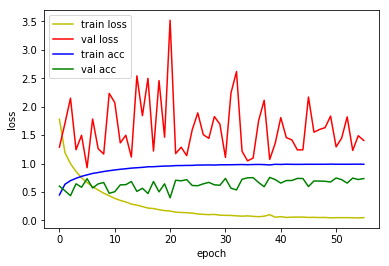

4815/4815 [==============================] - 4s 923us/sample - loss: 1.0521 - acc: 0.6947
Loss: 1.0520976801156254 Accuracy: 0.69470406

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8395 - acc: 0.4285
Epoch 00001: val_loss improved from inf to 1.48074, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_6_conv_checkpoint/001-1.4807.hdf5
36805/36805 [==============================] - 98s 3ms/sample - loss: 1.8393 - acc: 0.4286 - val_loss: 1.4807 - val_acc: 0.5395
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2432 - acc: 0.6212
Epoch 00002: val_loss did not improve from 1.48074
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.2431 - acc: 0.6212 - val_loss: 1.5299 - val_acc: 0.5206
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0457 - acc: 0.6857
Epoch 00003: val_loss did not improve from 1.48074
36805/36805 [====

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2286 - acc: 0.9366
Epoch 00028: val_loss improved from 0.86941 to 0.79614, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_6_conv_checkpoint/028-0.7961.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2286 - acc: 0.9366 - val_loss: 0.7961 - val_acc: 0.7857
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2186 - acc: 0.9388
Epoch 00029: val_loss did not improve from 0.79614
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2186 - acc: 0.9388 - val_loss: 1.4004 - val_acc: 0.6669
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2074 - acc: 0.9426
Epoch 00030: val_loss did not improve from 0.79614
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2076 - acc: 0.9426 - val_loss: 1.2657 - val_acc: 0.7174
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9806
Epoch 00057: val_loss did not improve from 0.78462
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0784 - acc: 0.9806 - val_loss: 1.9339 - val_acc: 0.6138
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0809 - acc: 0.9799
Epoch 00058: val_loss did not improve from 0.78462
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0809 - acc: 0.9799 - val_loss: 0.8546 - val_acc: 0.7969
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0756 - acc: 0.9811
Epoch 00059: val_loss did not improve from 0.78462
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0756 - acc: 0.9811 - val_loss: 0.8312 - val_acc: 0.8027
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0793 - acc: 0.9801
Epoch 00060: val_loss did not improve from 0.78462
36805/36805 [===========

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0506 - acc: 0.9873
Epoch 00087: val_loss improved from 0.78462 to 0.75632, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_6_conv_checkpoint/087-0.7563.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0506 - acc: 0.9873 - val_loss: 0.7563 - val_acc: 0.8395
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9890
Epoch 00088: val_loss did not improve from 0.75632
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0460 - acc: 0.9890 - val_loss: 0.9761 - val_acc: 0.7948
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0504 - acc: 0.9868
Epoch 00089: val_loss did not improve from 0.75632
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0504 - acc: 0.9868 - val_loss: 0.7848 - val_acc: 0.8390
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9880
Epoch 00116: val_loss did not improve from 0.75632
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0431 - acc: 0.9880 - val_loss: 1.6485 - val_acc: 0.7202
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0436 - acc: 0.9892
Epoch 00117: val_loss did not improve from 0.75632
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0436 - acc: 0.9892 - val_loss: 1.0949 - val_acc: 0.7906
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9918
Epoch 00118: val_loss did not improve from 0.75632
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0351 - acc: 0.9918 - val_loss: 0.8785 - val_acc: 0.8218
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9882
Epoch 00119: val_loss did not improve from 0.75632
36805/36805 [=====================

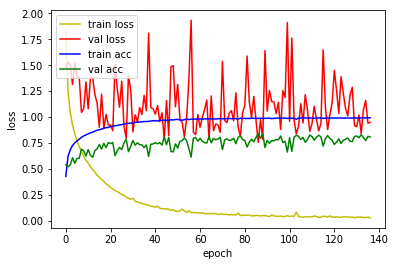

4815/4815 [==============================] - 5s 944us/sample - loss: 0.8392 - acc: 0.8150
Loss: 0.8392356582148425 Accuracy: 0.81495327

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9117 - acc: 0.4002
Epoch 00001: val_loss improved from inf to 1.47832, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_7_conv_checkpoint/001-1.4783.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 1.9117 - acc: 0.4002 - val_loss: 1.4783 - val_acc: 0.5409
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2842 - acc: 0.6077
Epoch 00002: val_loss did not improve from 1.47832
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.2841 - acc: 0.6078 - val_loss: 1.7665 - val_acc: 0.4987
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0577 - acc: 0.6834
Epoch 00003: val_loss improved from 1.47832 to 1.12850, saving mode

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2352 - acc: 0.9326
Epoch 00028: val_loss improved from 0.68117 to 0.56293, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_7_conv_checkpoint/028-0.5629.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2352 - acc: 0.9325 - val_loss: 0.5629 - val_acc: 0.8381
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2216 - acc: 0.9352
Epoch 00029: val_loss improved from 0.56293 to 0.53260, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_7_conv_checkpoint/029-0.5326.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2216 - acc: 0.9352 - val_loss: 0.5326 - val_acc: 0.8523
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2102 - acc: 0.9391
Epoch 00030: val_loss did not improve from 0.53260
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.2102 - acc: 0.9391 -

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0845 - acc: 0.9762
Epoch 00057: val_loss did not improve from 0.44250
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0846 - acc: 0.9762 - val_loss: 0.5320 - val_acc: 0.8698
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0913 - acc: 0.9732
Epoch 00058: val_loss did not improve from 0.44250
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0913 - acc: 0.9732 - val_loss: 0.4654 - val_acc: 0.8735
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0778 - acc: 0.9785
Epoch 00059: val_loss did not improve from 0.44250
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0779 - acc: 0.9785 - val_loss: 1.1232 - val_acc: 0.7624
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0870 - acc: 0.9755
Epoch 00060: val_loss did not improve from 0.44250
36805/36805 [===========

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9861
Epoch 00087: val_loss did not improve from 0.44250
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0487 - acc: 0.9861 - val_loss: 0.6473 - val_acc: 0.8505
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9851
Epoch 00088: val_loss did not improve from 0.44250
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0519 - acc: 0.9851 - val_loss: 0.6594 - val_acc: 0.8507
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9859
Epoch 00089: val_loss did not improve from 0.44250
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0497 - acc: 0.9859 - val_loss: 0.7636 - val_acc: 0.8372
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9882
Epoch 00090: val_loss did not improve from 0.44250
36805/36805 [===========

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9915
Epoch 00116: val_loss did not improve from 0.40170
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0322 - acc: 0.9915 - val_loss: 0.5542 - val_acc: 0.8824
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9903
Epoch 00117: val_loss did not improve from 0.40170
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0360 - acc: 0.9903 - val_loss: 0.4750 - val_acc: 0.8903
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9877
Epoch 00118: val_loss did not improve from 0.40170
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0410 - acc: 0.9876 - val_loss: 0.6274 - val_acc: 0.8593
Epoch 119/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9896
Epoch 00119: val_loss did not improve from 0.40170
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9923
Epoch 00145: val_loss did not improve from 0.39387
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0275 - acc: 0.9923 - val_loss: 0.6583 - val_acc: 0.8651
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9899
Epoch 00146: val_loss improved from 0.39387 to 0.37927, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_7_conv_checkpoint/146-0.3793.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0374 - acc: 0.9899 - val_loss: 0.3793 - val_acc: 0.9173
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9944
Epoch 00147: val_loss did not improve from 0.37927
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0209 - acc: 0.9944 - val_loss: 0.8529 - val_acc: 0.8446
Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0301 - acc: 0.9906
Epoch 00174: val_loss did not improve from 0.37927
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0301 - acc: 0.9906 - val_loss: 0.6987 - val_acc: 0.8651
Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9954
Epoch 00175: val_loss did not improve from 0.37927
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0168 - acc: 0.9954 - val_loss: 0.7632 - val_acc: 0.8472
Epoch 176/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0247 - acc: 0.9927
Epoch 00176: val_loss did not improve from 0.37927
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0248 - acc: 0.9927 - val_loss: 0.4823 - val_acc: 0.9033
Epoch 177/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9902
Epoch 00177: val_loss did not improve from 0.37927
36805/36805 [=====================

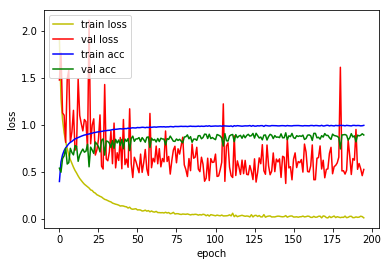

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4731 - acc: 0.8922
Loss: 0.47306517379925134 Accuracy: 0.89221185

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9186 - acc: 0.3985
Epoch 00001: val_loss improved from inf to 1.42298, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_8_conv_checkpoint/001-1.4230.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.9186 - acc: 0.3985 - val_loss: 1.4230 - val_acc: 0.5539
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2579 - acc: 0.6180
Epoch 00002: val_loss improved from 1.42298 to 1.27944, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_8_conv_checkpoint/002-1.2794.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.2580 - acc: 0.6180 - val_loss: 1.2794 - val_acc: 0.6173
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9612
Epoch 00026: val_loss did not improve from 0.26093
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1342 - acc: 0.9612 - val_loss: 0.3961 - val_acc: 0.8968
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9635
Epoch 00027: val_loss did not improve from 0.26093
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1299 - acc: 0.9635 - val_loss: 0.3303 - val_acc: 0.9096
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1300 - acc: 0.9624
Epoch 00028: val_loss did not improve from 0.26093
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1300 - acc: 0.9624 - val_loss: 0.2747 - val_acc: 0.9255
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1182 - acc: 0.9664
Epoch 00029: val_loss did not improve from 0.26093
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9887
Epoch 00055: val_loss did not improve from 0.23016
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0404 - acc: 0.9887 - val_loss: 0.3014 - val_acc: 0.9220
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9915
Epoch 00056: val_loss did not improve from 0.23016
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0339 - acc: 0.9915 - val_loss: 0.3162 - val_acc: 0.9199
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9879
Epoch 00057: val_loss did not improve from 0.23016
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0449 - acc: 0.9879 - val_loss: 0.3520 - val_acc: 0.9157
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9920
Epoch 00058: val_loss did not improve from 0.23016
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9915
Epoch 00085: val_loss did not improve from 0.23016
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0314 - acc: 0.9915 - val_loss: 0.2442 - val_acc: 0.9427
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9937
Epoch 00086: val_loss did not improve from 0.23016
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0229 - acc: 0.9937 - val_loss: 0.2673 - val_acc: 0.9408
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9934
Epoch 00087: val_loss did not improve from 0.23016
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0229 - acc: 0.9934 - val_loss: 0.2378 - val_acc: 0.9474
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9955
Epoch 00088: val_loss did not improve from 0.23016
36805/36805 [===========

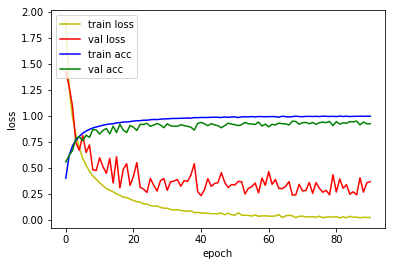

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2912 - acc: 0.9169
Loss: 0.2912467776614929 Accuracy: 0.91692626

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6693 - acc: 0.4859
Epoch 00001: val_loss improved from inf to 1.10973, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_9_conv_checkpoint/001-1.1097.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.6692 - acc: 0.4859 - val_loss: 1.1097 - val_acc: 0.6662
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9181 - acc: 0.7257
Epoch 00002: val_loss improved from 1.10973 to 0.76647, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_025_DO_BN_9_conv_checkpoint/002-0.7665.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.9180 - acc: 0.7257 - val_loss: 0.7665 - val_acc: 0.7619
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0499 - acc: 0.9864
Epoch 00026: val_loss did not improve from 0.20133
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0499 - acc: 0.9864 - val_loss: 0.2658 - val_acc: 0.9238
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9889
Epoch 00027: val_loss did not improve from 0.20133
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0429 - acc: 0.9889 - val_loss: 0.2768 - val_acc: 0.9194
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9852
Epoch 00028: val_loss did not improve from 0.20133
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0543 - acc: 0.9852 - val_loss: 0.2955 - val_acc: 0.9117
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9899
Epoch 00029: val_loss did not improve from 0.20133
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9977
Epoch 00055: val_loss did not improve from 0.19297
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0096 - acc: 0.9977 - val_loss: 0.2190 - val_acc: 0.9462
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0177 - acc: 0.9955
Epoch 00056: val_loss did not improve from 0.19297
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0177 - acc: 0.9955 - val_loss: 0.2345 - val_acc: 0.9448
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9944
Epoch 00057: val_loss did not improve from 0.19297
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0202 - acc: 0.9944 - val_loss: 0.1999 - val_acc: 0.9532
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9969
Epoch 00058: val_loss did not improve from 0.19297
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0085 - acc: 0.9979
Epoch 00084: val_loss did not improve from 0.17436
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0085 - acc: 0.9978 - val_loss: 0.2280 - val_acc: 0.9453
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9959
Epoch 00085: val_loss did not improve from 0.17436
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0151 - acc: 0.9958 - val_loss: 0.2132 - val_acc: 0.9541
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9956
Epoch 00086: val_loss did not improve from 0.17436
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0154 - acc: 0.9956 - val_loss: 0.1945 - val_acc: 0.9562
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.9998
Epoch 00087: val_loss did not improve from 0.17436
36805/36805 [========================

Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9948
Epoch 00114: val_loss did not improve from 0.17436
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0179 - acc: 0.9948 - val_loss: 0.1848 - val_acc: 0.9599
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9995
Epoch 00115: val_loss did not improve from 0.17436
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0033 - acc: 0.9995 - val_loss: 0.1862 - val_acc: 0.9590
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9996
Epoch 00116: val_loss did not improve from 0.17436
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0026 - acc: 0.9996 - val_loss: 0.2080 - val_acc: 0.9534
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9992
Epoch 00117: val_loss did not improve from 0.17436
36805/36805 [=======

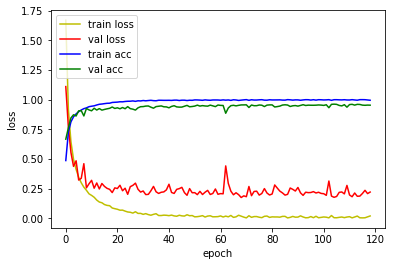

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2331 - acc: 0.9439
Loss: 0.23307212622312062 Accuracy: 0.94392526



In [10]:
base = '1D_CNN_custom_tanh_DO_025_DO_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_DO_025_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_025_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
________________

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.3915 - acc: 0.6079
Loss: 1.3915153474698805 Accuracy: 0.607892

1D_CNN_custom_tanh_DO_025_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.4731 - acc: 0.8922
Loss: 0.47306517379925134 Accuracy: 0.89221185

1D_CNN_custom_tanh_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation) 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2331 - acc: 0.9439
Loss: 0.23307212622312062 Accuracy: 0.94392526


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_025_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,656
Trainable params: 16,384,528
Non-trainable params: 128
________________

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.8324 - acc: 0.6465
Loss: 1.832364528399514 Accuracy: 0.6465213

1D_CNN_custom_tanh_DO_025_DO_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_55 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_56 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_56 (Activation)   (

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6750 - acc: 0.8685
Loss: 0.6750180344220139 Accuracy: 0.8685358

1D_CNN_custom_tanh_DO_025_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_73 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_74 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_74 (Activation)   

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2417 - acc: 0.9441
Loss: 0.24172403020677877 Accuracy: 0.9441329
